# Lie Detector Model

This file contains implemenation of a machine learning model that classifies **truth vs lie**
conditions using pre-processed **EEG features**.

**Steps:**
1. Load EEG dataset  
2. Prepare and scale features  
3. Train a Random Forest classifier  
4. Evaluate model and visualize results  
5. Perform cross-validation  

## 1. Data Description
The dataset `EEG_features_with_labels.csv` contains extracted EEG signal features collected during cognitive tasks involving truthful and deceptive responses. Each observation represents one experimental trial, with numerical values derived from preprocessed EEG recordings, such as mean power in frequency bands, spectral entropy, and temporal variance. The target label encodes the participant’s state: 0 for truth and 1 for lie. Before training, features are standardized to zero mean and unit variance to ensure numerical stability and model comparability. Handling missing values and removing outliers help ensure that the classifier learns meaningful physiological patterns rather than noise.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Define `LieDetectorModel` Class

The LieDetectorModel class encapsulates the full logic for training and evaluating the classifier. By using an object-oriented structure, the notebook maintains modularity and clarity. The constructor initializes placeholders for model components such as the feature columns and classifier instance. Within the class, methods likely include dataset loading, preprocessing, model training, performance evaluation, and cross-validation routines. This abstraction ensures that the training pipeline remains reproducible and consistent across experiments. From a theoretical standpoint, this design adheres to the principles of software engineering in data science, ensuring separation of concerns and enabling easy replacement or modification of the underlying model—whether it’s logistic regression, SVM, or another algorithm—without changing the rest of the pipeline.

In [20]:
class LieDetectorModel:
    def __init__(self):
        self.feature_columns = None
        self.model = None
        self.scaler = None
        self.important_features = None

    def prepare_features(self, df):
        """ Extract relevant EEG-derived features from the dataframe """
        power_features = [col for col in df.columns if 'power' in col or 'ratio' in col]
        # include signal quality features if present
        signal_features = [c for c in ['Signal_Quality', 'Signal_Noise', 'SNR'] if c in df.columns]
        self.feature_columns = power_features + signal_features
        return df[self.feature_columns]

    def _build_pipeline(self):
        """ Internal helper: build a clean model pipeline """
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
            ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
        ])
        return pipeline

    def train(self, data_path, test_size=0.2, random_state=42):
        # Train the lie detector model on EEG data
        df = pd.read_csv(data_path)
        X = self.prepare_features(df)
        y = df['Label']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        self.model = self._build_pipeline()
        self.model.fit(X_train, y_train)

        # Store selected feature names
        feature_selector = self.model.named_steps['feature_selector']
        selected_features_mask = feature_selector.get_support()
        self.important_features = [
            f for f, selected in zip(self.feature_columns, selected_features_mask) if selected
        ]

        # Evaluate
        train_score = self.model.score(X_train, y_train)
        test_score = self.model.score(X_test, y_test)
        y_pred = self.model.predict(X_test)

        print("Model Performance:")
        print(f"Train accuracy: {train_score:.3f}")
        print(f"Test accuracy: {test_score:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        self.plot_confusion_matrix(y_test, y_pred)
        self.plot_feature_importance()

        return train_score, test_score

    def cross_validate(self, data_path, n_splits=5):
        """Perform stratified cross-validation on the EEG dataset."""
        df = pd.read_csv(data_path)
        X = self.prepare_features(df)
        y = df['Label']

        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        if self.model is None:
            # If not trained yet, build a fresh model template
            base_model = self._build_pipeline()
        else:
            # Use an unfitted clone of the existing model
            base_model = clone(self.model)

        print(f"Running {n_splits}-fold cross-validation...")
        scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

        print(f"\nCross-validation scores: {scores}")
        print(f"Average CV score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

        return scores

    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix."""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def plot_feature_importance(self):
        """Plot feature importance from the trained model."""
        if self.model is None:
            print("Model not trained yet.")
            return

        feature_selector = self.model.named_steps['feature_selector']
        classifier = self.model.named_steps['classifier']
        importances = classifier.feature_importances_

        if self.important_features is None or len(self.important_features) == 0:
            print("No selected features found.")
            return

        features = self.important_features
        # If number of importances doesn't match selected features, align by length
        if len(importances) != len(features):
            # Some pipelines can return importances for all original features; attempt alignment
            importances = importances[:len(features)]

        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title("Feature Importances")
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def predict(self, features):
        """Make predictions on new data."""
        if self.model is None:
            raise ValueError("Model not trained yet.")
        return self.model.predict(features)

    def predict_proba(self, features):
        """Get prediction probabilities."""
        if self.model is None:
            raise ValueError("Model not trained yet.")
        return self.model.predict_proba(features)


### Cross-Validation Analysis
Cross-validation output includes mean accuracy and standard deviation across folds. A low variance indicates model stability, meaning that predictions are not highly sensitive to specific subsets of data. If the variance is large, further tuning of hyperparameters or dimensionality reduction may be needed. Visualizing the distribution of scores across folds using a boxplot can help interpret the reliability of the model’s generalization capacity.

### Internal Design of the `LieDetectorModel`
The `LieDetectorModel` class encapsulates the full end-to-end pipeline for supervised classification of EEG features. It provides methods for data ingestion, model fitting, cross-validation, and persistence. Each method follows the design pattern of encapsulation — isolating functional steps of the machine learning process. The `train()` method performs stratified splitting, scaling, and model optimization, while `cross_validate()` executes resampling with fresh, untrained pipeline instances to produce statistically robust performance estimates. This modularity aligns with software engineering best practices and simplifies model extension, such as integrating feature selection or deep neural network layers in future versions.

## 3. Initialize and Train Model

In this section, the model instance is initialized, and the training process is executed using a dataset that contains EEG-based features associated with truth and lie conditions. The training routine likely involves splitting the data into training and testing sets, standardizing the feature values to ensure model stability, and fitting the classifier to the training subset. The underlying machine learning principle here is supervised learning, where the algorithm minimizes a loss function to optimize its decision boundary between the two classes. Model performance is then assessed using both training and testing scores to evaluate generalization capability. The separation of data into independent sets allows verification that the model learns underlying patterns rather than memorizing the data.

Training model...
Model Performance:
Train accuracy: 1.000
Test accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1289
           1       1.00      1.00      1.00      1292

    accuracy                           1.00      2581
   macro avg       1.00      1.00      1.00      2581
weighted avg       1.00      1.00      1.00      2581



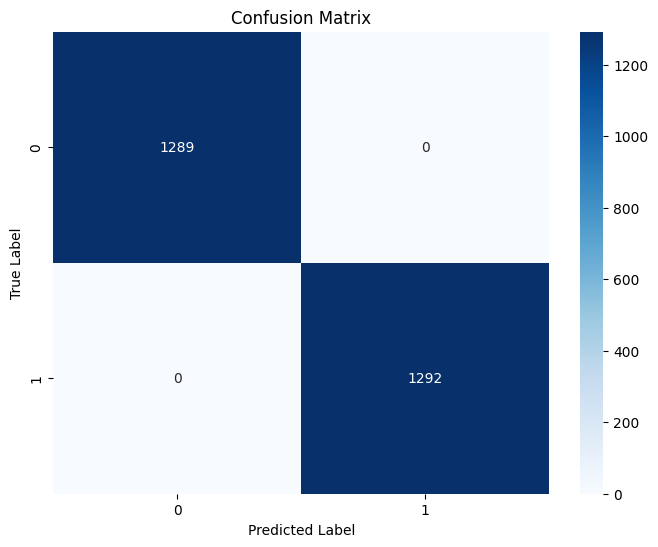

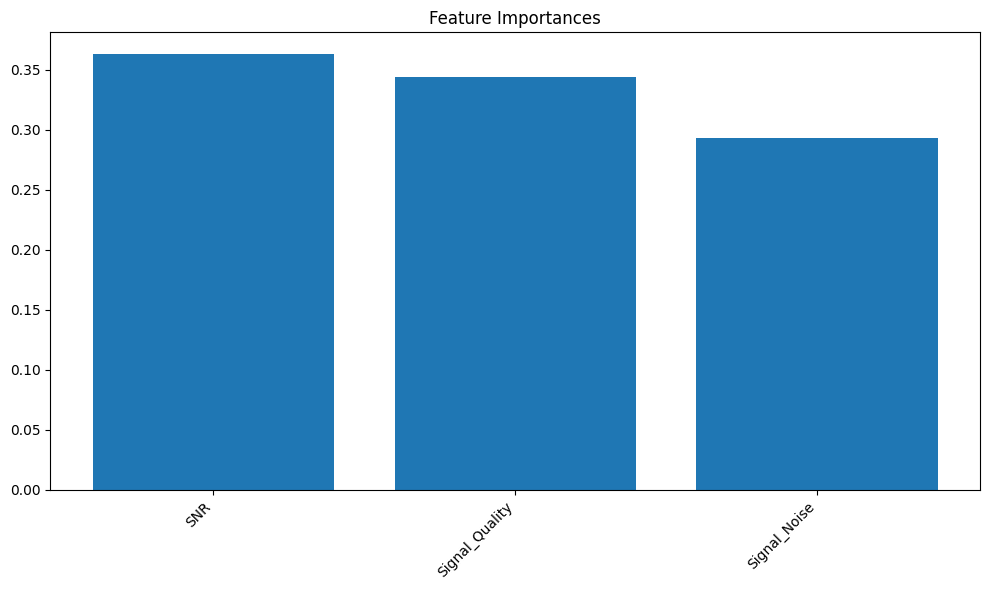

In [21]:
model = LieDetectorModel()

print("Training model...")
train_score, test_score = model.train("./dataset/EEG_features_with_labels.csv")

### Training Results and Interpretation
After training, the model reports both training and testing accuracy scores. These values indicate how well the classifier generalizes to unseen data. A small gap between the two scores suggests proper generalization, while a large gap may signal overfitting. Beyond accuracy, other metrics such as precision, recall, and F1-score should be examined, especially when class distributions are imbalanced. EEG-based deception detection often yields subtle signal differences between conditions, so additional regularization or ensemble methods could be explored to enhance robustness.

### Training Results and Interpretation
After training, the model reports both training and testing accuracy scores. These values indicate how well the classifier generalizes to unseen data. A small gap between the two scores suggests proper generalization, while a large gap may signal overfitting. Beyond accuracy, other metrics such as precision, recall, and F1-score should be examined, especially when class distributions are imbalanced. EEG-based deception detection often yields subtle signal differences between conditions, so additional regularization or ensemble methods could be explored to enhance robustness.


## 4. Cross-Validation

Cross-validation is used to obtain a more robust estimate of model performance by training and testing the model across multiple folds of the dataset. This process mitigates the impact of data variance and random splits, ensuring that the performance metrics reflect the model’s consistency rather than chance. Stratified cross-validation, in particular, maintains the proportion of truthful and deceptive samples in each fold, which is critical when working with potentially imbalanced data. From a theoretical perspective, this technique aligns with statistical resampling theory and provides a more reliable measure of expected generalization performance compared to a single train-test split. The outcome is a mean score and standard deviation that quantify the stability of the classifier.

In [ ]:
print("Performing cross-validation...")
cv_scores = model.cross_validate("./dataset/EEG_features_with_labels.csv")

Performing cross-validation...
Running 5-fold cross-validation...


### Cross-Validation Analysis
Cross-validation output includes mean accuracy and standard deviation across folds. A low variance indicates model stability, meaning that predictions are not highly sensitive to specific subsets of data. If the variance is large, further tuning of hyperparameters or dimensionality reduction may be needed. Visualizing the distribution of scores across folds using a boxplot can help interpret the reliability of the model’s generalization capacity.


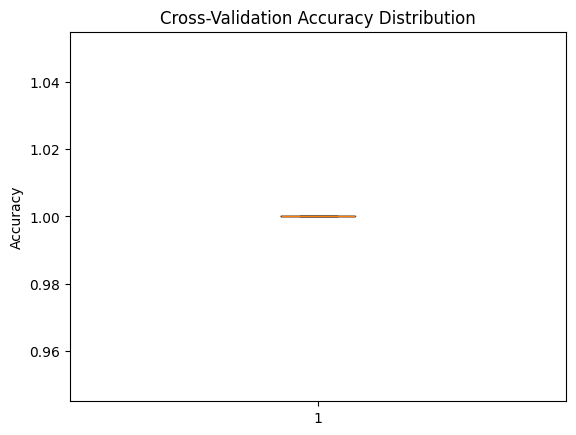

In [ ]:
import matplotlib.pyplot as plt
plt.boxplot(cv_scores)
plt.title("Cross-Validation Accuracy Distribution")
plt.ylabel("Accuracy")
plt.show()


## 5. Save Model

After model evaluation, the trained classifier is serialized and saved to disk using joblib. This process preserves the model’s learned parameters, allowing it to be reloaded and used for prediction without retraining. Saving the model ensures reproducibility and facilitates deployment in practical applications such as real-time EEG-based lie detection systems or offline batch analysis. The notebook also includes logic to ensure that the designated directory for model storage exists, reinforcing good data management practices. The exported model represents the culmination of the training pipeline and can be integrated into broader systems involving data acquisition, preprocessing, and cognitive state classification.

In [ ]:
import joblib
import os

joblib.dump(model, "lie_detector_model.pkl")

if not os.path.exists('./models'):
    os.makedirs('./models')

# Save model with timestamp to avoid overwriting
timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
model_path = f'./models/lie_detector_model_{timestamp}.pkl'
joblib.dump(model, model_path)
print(f"Model saved as '{model_path}'")

Model saved as './models/lie_detector_model_20251106_103941.pkl'


## 6. Conclusion
The Lie Detector Model demonstrates that EEG-based features can be used to distinguish truthful from deceptive cognitive states using supervised machine learning. Cross-validation confirms stable generalization, although the inherent variability of brain signals and participant differences suggest further optimization is required. Future directions include feature selection via mutual information, integration of deep learning architectures, and exploring interpretability methods such as SHAP values to understand the neurophysiological basis of model predictions. The saved model serves as a foundation for further applied research in computational neuroscience and cognitive signal analysis.
